## Matched beer datasets

In [1]:
#Imports libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 1/ beers.csv files

In [ ]:
##Reading the beer.csv file as a dataframe
beers_df = pd.read_csv(os.path.join(DATA_FOLDER, 'matched_beer_data/beers.csv'), low_memory=False)

##Make a copy of the beers_df, rename the column names and remove the first row indexed with 0 since it is now merged in the column names
beers_df_copy=beers_df.copy()
beers_df_copy= beers_df_copy.rename(columns={'ba': 'ba_abv', 'ba.1': 'ba_avg', 'ba.2': 'ba_avg_computed', 'ba.3': 'ba_avg_matched_valid_ratings', 'ba.4': 'ba_score', 
                                             'ba.5': 'ba_beer_id', 'ba.6': 'ba_beer_name', 'ba.7': 'ba_beer_wout_brewery_name','ba.8':'ba_brewery_id',
                                             'ba.9': 'ba_brewery_name','ba.10': 'ba_bros_score', 'ba.11': 'ba_nbr_matched_valid_ratings', 'ba.12': 'ba_nbr_ratings', 
                                             'ba.13': 'ba_nbr_reviews', 'ba.14': 'ba_style', 'ba.15': 'ba_zscore', 
                                             'rb': 'rb_abv','rb.1': 'rb_avg', 'rb.2': 'rb_avg_computed', 'rb.3': 'rb_avg_matched_valid_ratings', 'rb.4': 'rb_beer_id', 
                                             'rb.5': 'rb_beer_name', 'rb.6': 'rb_beer_wout_brewery_name', 'rb.7': 'rb_brewery_id', 'rb.8': 'rb_brewery_name', 
                                             'rb.9': 'rb_nbr_matched_valid_ratings', 'rb.10': 'rb_nbr_ratings', 'rb.11': 'rb_overall_score', 'rb.12': 'rb_style', 
                                             'rb.13': 'rb_style_score', 'rb.14': 'rb_zscore', 'scores': 'scores_diff', 'scores.1': 'scores_sim'}) 
beers_df_copy = beers_df_copy.drop(index=0)
beers_df_copy = beers_df_copy.reset_index(drop=True)

##Remove some columns that are not relevant for the scope of our project
beers_df_copy= beers_df_copy.drop(columns=['ba_avg_computed', 'ba_beer_id', 'ba_beer_wout_brewery_name',
                                            'ba_brewery_id', 'rb_avg_computed', 'rb_beer_id', 'scores_diff', 'scores_sim'])

display(beers_df_copy.head())
print('The shape of the dataframe for the beers.csv file is:', beers_df.shape)


FileNotFoundError: [Errno 2] No such file or directory: './matched_beer_data/beers.csv'

In [3]:
##Check for which columns there are NaN values
display(beers_df_copy.isna().any())

ba_abv                          False
ba_avg                           True
ba_avg_matched_valid_ratings     True
ba_score                         True
ba_beer_name                    False
ba_brewery_name                 False
ba_bros_score                    True
ba_nbr_matched_valid_ratings    False
ba_nbr_ratings                  False
ba_nbr_reviews                  False
ba_style                        False
ba_zscore                        True
rb_abv                          False
rb_avg                           True
rb_avg_matched_valid_ratings     True
rb_beer_name                    False
rb_beer_wout_brewery_name       False
rb_brewery_id                   False
rb_brewery_name                 False
rb_nbr_matched_valid_ratings    False
rb_nbr_ratings                  False
rb_overall_score                 True
rb_style                        False
rb_style_score                   True
rb_zscore                        True
dtype: bool

Comments: 
- There are several columns having NaN values for both websites Beer Advocate (BA) and Rate Beer (RB). 
- Most of these columns corresponds to different scores such as ba_score, ba_bros_score, rb_overall_score, rb_style_score, etc

In [4]:
##Make a new dataframe with columns style, score and source (ba or rb)
beers_subset_df= pd.melt(beers_df_copy[['ba_score', 'ba_style', 'rb_overall_score', 'rb_style']], 
                    id_vars=['ba_style', 'rb_style'], 
                    value_vars=['ba_score', 'rb_overall_score'],
                    var_name='source', 
                    value_name='score')
beers_subset_df['source'] = beers_subset_df['source'].replace({'ba_score': 'BA', 'rb_overall_score': 'RB'})
beers_subset_df['style'] = beers_subset_df.apply(lambda row: row['ba_style'] if row['source'] == 'BA' else row['rb_style'], axis=1)
beers_subset_df = beers_subset_df.drop(columns=['ba_style', 'rb_style'])
beers_subset_df['score'] = pd.to_numeric(beers_subset_df['score'], errors='coerce')
beers_subset_df = beers_subset_df.dropna()
beers_subset_df = beers_subset_df.reset_index()

##Group by style and check if each style has both 'BA' and 'RB' sources and filter to keep only styles that have scores from both 'BA' and 'RB'
styles_with_both_sources = beers_subset_df.groupby('style')['source'].nunique() == 2
beers_subset_df = beers_subset_df[beers_subset_df['style'].isin(styles_with_both_sources[styles_with_both_sources].index)]
display(beers_subset_df.head())

##Get unique styles and count them
unique_styles = beers_subset_df['style'].unique()
num_styles = len(unique_styles)
print("Number of unique styles that have scores from both website BA and RB and no NaN values is:", num_styles)

,index,source,score,style
0,0,BA,80.0,English Pale Ale
15,267,BA,85.0,English Pale Ale
16,276,BA,85.0,English Pale Ale
18,286,BA,84.0,Scottish Ale
21,309,BA,91.0,Old Ale


Number of unique styles that have scores from both website BA and RB and no NaN values is: 14


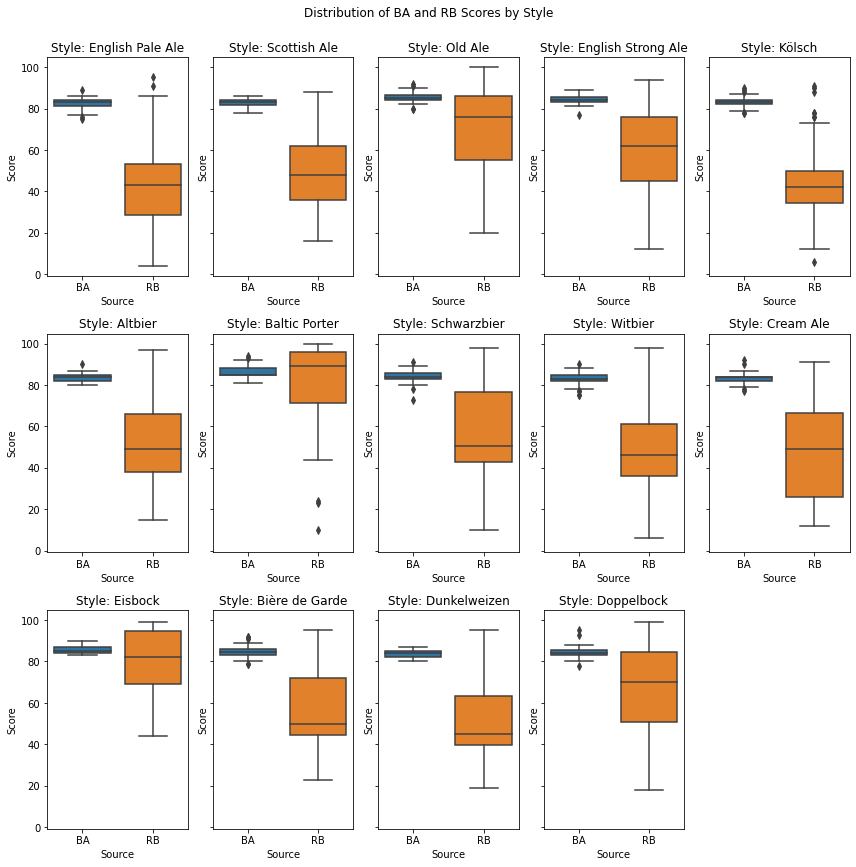

In [5]:
## Plot the distribution of the BA and RB scores only for styles having scores form both websites
ncols = 5
nrows = int(np.ceil(num_styles / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharey=True)
axes = axes.flatten()
for i, style in enumerate(unique_styles):
    sns.boxplot(data=beers_subset_df.loc[beers_subset_df['style'] == style], x='source', y='score', ax=axes[i])
    axes[i].set_title(f"Style: {style}")
    axes[i].set_xlabel("Source")
    axes[i].set_ylabel("Score")
#Hide any unused axes if num_styles is less than total subplot slots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Distribution of BA and RB Scores by Style", y=1)
plt.tight_layout()
plt.show()

Comments:
- Here we plotted the distribution of the score for BA and the overall score for RB to explore how these different scores vary in both websites. 
- These subplots show that the score from BA are spanned over a smaller range compared to the overall_score from RB. 
- The RB score varies more significantly across the different styles compared to BA score!

### 2/ breweries.csv files

In [6]:
##Reading the breweries.csv file as a dataframe
breweries_df = pd.read_csv('./matched_beer_data/breweries.csv', low_memory=False)

##Make a copy of the breweries_df, rename the column names and remove the first row indexed with 0 since it is now merged in the column names
breweries_df_copy=breweries_df.copy()
breweries_df_copy= breweries_df_copy.rename(columns={'ba': 'ba_brewery_id', 'ba.1': 'ba_location', 'ba.2': 'ba_brewery_name', 'ba.3': 'ba_nbr_beers', 
                                             'rb': 'rb_brewery_id','rb.1': 'rb_location', 'rb.2': 'rb_brewery_name', 'rb.3': 'rb_nbr_beers', 'scores': 'scores_diff', 'scores.1': 'scores_sim'}) 
breweries_df_copy = breweries_df_copy.drop(index=0)
breweries_df_copy = breweries_df_copy.reset_index(drop=True)

##Remove some columns that are not relevant for the scope of our project
breweries_df_copy= breweries_df_copy.drop(columns=['ba_brewery_id', 'rb_brewery_id', 'scores_diff', 'scores_sim'])

display(breweries_df_copy.head())
print('The shape of the dataframe for the beers.csv file is:', breweries_df_copy.shape)

,ba_location,ba_brewery_name,ba_nbr_beers,rb_location,rb_brewery_name,rb_nbr_beers
0,Northern Ireland,Strangford Lough Brewing Company Ltd,5,Northern Ireland,Strangford Lough,5
1,Northern Ireland,The Sheelin Brewery,4,Northern Ireland,Sheelin,2
2,Northern Ireland,Walled City Brewing Company,6,Northern Ireland,Walled City,3
3,Northern Ireland,Ards Brewing Company,7,Northern Ireland,Ards Brewing Co.,13
4,Northern Ireland,Barrahooley Brewery,3,Northern Ireland,Barrahooley Craft Brewery,4


The shape of the dataframe for the beers.csv file is: (8281, 6)


In [29]:
##Group by ba_location and count breweries
ba_counts = breweries_df_copy.groupby('ba_location')['ba_brewery_name'].count().reset_index()
ba_counts.columns = ['location', 'number_of_breweries_per_location_ba']

##Group by rb_location and count breweries  
rb_counts =breweries_df_copy.groupby('rb_location')['rb_brewery_name'].count().reset_index()
rb_counts.columns = ['location', 'number_of_breweries_per_location_rb']

##Combine the results of both ba and rb
result_df = pd.merge(ba_counts, rb_counts, on='location')
result_df = result_df.sort_values(by='number_of_breweries_per_location_ba', ascending=False)
display(result_df.head())

##Function to plot the number of breweries per location
def plot_top_n_breweries(n):
    # Select top N locations
    top_result_df = result_df.nlargest(n, 'number_of_breweries_per_location_ba')

    # Plotting
    x = np.arange(len(top_result_df))
    width = 0.2
    plt.figure(figsize=(10, 10))
    plt.bar(x - width/2, top_result_df['number_of_breweries_per_location_ba'], width, label='BA website')
    plt.bar(x + width/2, top_result_df['number_of_breweries_per_location_rb'], width, label='RB website')
    plt.yscale('log')
    plt.title(f'Number of Breweries per Location (Top {n} Countries)')
    plt.xlabel('Location (Country)')
    plt.ylabel('Number of Breweries (Log Scale)')
    plt.xticks(x, top_result_df['location'], rotation=45, ha='right', fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()

##Create a slider to select the number of top countries and display it
n_slider = widgets.IntSlider(value=10, min=1, max=result_df['location'].unique().size, step=1, description="Top N Countries")
widgets.interactive(plot_top_n_breweries, n=n_slider)


,location,number_of_breweries_per_location_ba,number_of_breweries_per_location_rb
51,Germany,530,530
40,England,482,482
151,"United States, California",454,454
20,Canada,407,407
152,"United States, Colorado",233,233


interactive(children=(IntSlider(value=10, description='Top N Countries', max=205, min=1), Output()), _dom_clas…

Comments:
- The plot above shows the distribution of the number of breweries per country for both BA and RB websites in a descendant way.
- We can also notice that the number is the same for both websites across all countries. 

### 3/ ratings.csv files

In [8]:
##Reading the ratings.csv file as a dataframe
ratings_df = pd.read_csv('./matched_beer_data/ratings.csv', low_memory=False)

##Make a copy of the ratings_df, rename the column names and remove the first row indexed with 0 since it is now merged in the column names
ratings_df_copy=ratings_df.copy()
ratings_df_copy= ratings_df_copy.rename(columns={'ba': 'ba_abv', 'ba.1': 'ba_appearance', 'ba.2': 'ba_aroma', 'ba.3': 'ba_beer_id', 'ba.4': 'ba_beer_name', 
                                                'ba.5': 'ba_brewery_id', 'ba.6': 'ba_brewery_name', 'ba.7': 'ba_date', 'ba.8': 'ba_overall', 'ba.9': 'ba_palate',
                                                'ba.10': 'ba_rating', 'ba.11': 'ba_review', 'ba.12': 'ba_style', 'ba.13': 'ba_taste', 'ba.14': 'ba_text', 
                                                'ba.15': 'ba_user_id', 'ba.16': 'ba_user_name', 'rb': 'rb_abv', 'rb.1': 'rb_appearance', 'rb.2': 'rb_aroma', 
                                                'rb.3': 'rb_beer_id', 'rb.4': 'rb_beer_name', 'rb.5': 'rb_brewery_id', 'rb.6': 'rb_brewery_name', 'rb.7': 'rb_date', 
                                                'rb.8': 'rb_overall', 'rb.9': 'rb_palate', 'rb.10': 'rb_rating', 'rb.11': 'rb_style', 'rb.12': 'rb_taste', 'rb.13': 'rb_text', 
                                                'rb.14': 'rb_user_id', 'rb.15': 'rb_user_name'}) 
ratings_df_copy = ratings_df_copy.drop(index=0)
ratings_df_copy = ratings_df_copy.reset_index(drop=True)

##Remove some columns that are not relevant for the scope of our project
ratings_df_copy= ratings_df_copy.drop(columns=['ba_beer_id', 'ba_brewery_id', 'ba_user_id', 'rb_beer_id', 'rb_brewery_id', 'rb_user_id'])

##Convert the date columns of both ba and rb to readable dates
ratings_df_copy['ba_date'] = pd.to_datetime(pd.to_numeric(ratings_df_copy['ba_date'], errors='coerce'), unit='s')
ratings_df_copy['rb_date'] = pd.to_datetime(pd.to_numeric(ratings_df_copy['rb_date'],errors='coerce'), unit='s')

display(ratings_df_copy.head())
print('The shape of the dataframe for the beers.csv file is:', ratings_df_copy.shape)


,ba_abv,ba_appearance,ba_aroma,ba_beer_name,ba_brewery_name,ba_date,ba_overall,ba_palate,ba_rating,ba_review,...,rb_beer_name,rb_brewery_name,rb_date,rb_overall,rb_palate,rb_rating,rb_style,rb_taste,rb_text,rb_user_name
0,11.3,4.5,4.5,Trappistes Rochefort 10,Brasserie de Rochefort,2011-12-25 11:00:00,5.0,4.5,4.8,True,...,Rochefort Trappistes 10,Brasserie Rochefort,2013-12-22 11:00:00,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,Erzengel
1,5.0,NaN,NaN,Myanmar Lager Beer,Myanmar Brewery and Distillery,2011-11-30 11:00:00,NaN,NaN,3.0,True,...,Myanmar Lager Beer,Myanmar Brewery and Distillery,2011-11-29 11:00:00,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",visionthing
2,5.0,3.5,3.5,Cantillon Tyrnilambic Baie D’Argousier Lambic,Brasserie Cantillon,2012-08-04 10:00:00,4.0,4.0,3.85,True,...,Cantillon Tyrnilambic Baie dArgousier,Cantillon,2012-11-22 11:00:00,17.0,4.0,4.1,Lambic Style - Fruit,8.0,"Bottle @ One Pint Pub, Helsinki. Originally ra...",tiong
3,5.0,4.0,3.5,Cantillon Pikkulinnun Viskilambic,Brasserie Cantillon,2012-08-04 10:00:00,4.0,4.0,3.68,True,...,Cantillon Pikkulinnun Viskilambic,Cantillon,2014-11-17 11:00:00,16.0,4.0,4.1,Lambic Style - Unblended,9.0,"Draught @Â Pikkulintu, Helsinki, Finland. A pr...",tiong
4,6.0,4.0,4.0,Drie Fonteinen Oude Geuze - Armand & Tommy,Brouwerij 3 Fonteinen,2012-08-29 10:00:00,4.0,4.0,4.0,True,...,3 Fonteinen Oude Geuze (Armand & Tommy),Brouwerij 3 Fonteinen,2012-08-18 10:00:00,16.0,4.0,4.0,Lambic Style - Gueuze,8.0,750ml bottleBottling date: 2011/02/17 - Pours ...,tiong


The shape of the dataframe for the beers.csv file is: (21964, 27)


In [9]:
##Check for which columns there are NaN values
display(ratings_df_copy.isna().any())

ba_abv             False
ba_appearance       True
ba_aroma            True
ba_beer_name       False
ba_brewery_name    False
ba_date            False
ba_overall          True
ba_palate           True
ba_rating          False
ba_review          False
ba_style           False
ba_taste            True
ba_text             True
ba_user_name       False
rb_abv             False
rb_appearance      False
rb_aroma           False
rb_beer_name       False
rb_brewery_name    False
rb_date            False
rb_overall         False
rb_palate          False
rb_rating          False
rb_style           False
rb_taste           False
rb_text            False
rb_user_name       False
dtype: bool

Comments:
- For the BA website, we notice that the columns corresponding to the following categories scores 'appearance', 'aroma', 'palate', 'taste', overall score and text contain some NaN values. However, for the RB website there are no NaN values for the same type of beers and breweries. 

In [ ]:
##Function to plot the boxplots for a selected number of styles
def plot_styles(num_styles, website):
    # Get the top `num_styles`
    selected_styles = ratings_df_copy_nonan_subset['style'].unique()[:num_styles]
    df_selected_styles = ratings_df_copy_nonan_subset[ratings_df_copy_nonan_subset['style'].isin(selected_styles)]

    #Plotting
    fig, axes = plt.subplots(num_styles, 1, figsize=(10, num_styles * 4), sharex=True)
    for i, (style, group_data) in enumerate(df_selected_styles.groupby('style')):
        sns.boxplot(data=group_data, x='category', y='score', ax=axes[i], hue='category')
        axes[i].set_title(f"Distribution of Appearance, Aroma, Palate, and Taste Scores for Style: {style}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Score")
        axes[i].legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Distribution of Scores by Style for {website}", y=1)
    plt.tight_layout()
    plt.show()


In [11]:
##Filter out rows with NaN values in relevant columns for RB website 
ratings_df_copy_nonan = ratings_df_copy.dropna(subset=['ba_appearance', 'ba_aroma', 'ba_palate', 'ba_taste'])
ratings_df_copy_nonan=ratings_df_copy_nonan.rename(columns={'ba_style': 'style'})

##Modify the DataFrame to have one column for the style, one for the category (appearance, aroma, etc.) and one for the score
ratings_df_copy_nonan_subset = ratings_df_copy_nonan.melt(id_vars=['style'], 
                             value_vars=['ba_appearance', 'ba_aroma', 'rb_palate', 'ba_taste'], 
                             var_name='category', 
                             value_name='score')
ratings_df_copy_nonan_subset['score'] = pd.to_numeric(ratings_df_copy_nonan_subset['score'], errors='coerce')
ratings_df_copy_nonan_subset['category'] = ratings_df_copy_nonan_subset['category'].str.replace('ba_', '', regex=False)


##Create an interactive widget with a slider for the number of styles and interactive plot
style_slider = widgets.IntSlider(value=5, min=1, max=len(ratings_df_copy_nonan_subset['style'].unique()), step=1, description='# of Styles:')
interactive_plot = interactive(plot_styles, num_styles=style_slider, website='BA')
ratings_df_copy_nonan=ratings_df_copy_nonan.rename(columns={'style': 'ba_style'})
display(interactive_plot)


interactive(children=(IntSlider(value=5, description='# of Styles:', max=104, min=1), Text(value='BA', descrip…

In [12]:
##Filter out rows with NaN values in relevant columns for RB website 
ratings_df_copy_nonan = ratings_df_copy.dropna(subset=['rb_appearance', 'rb_aroma', 'rb_palate', 'rb_taste'])
ratings_df_copy_nonan=ratings_df_copy_nonan.rename(columns={'rb_style': 'style'})

##Modify the DataFrame to have one column for the style, one for the category (appearance, aroma, etc.) and one for the score
ratings_df_copy_nonan_subset = ratings_df_copy_nonan.melt(id_vars=['style'], 
                             value_vars=['rb_appearance', 'rb_aroma', 'rb_palate', 'rb_taste'], 
                             var_name='category', 
                             value_name='score')

ratings_df_copy_nonan_subset['score'] = pd.to_numeric(ratings_df_copy_nonan_subset['score'], errors='coerce')
ratings_df_copy_nonan_subset['category'] = ratings_df_copy_nonan_subset['category'].str.replace('rb_', '', regex=False)


##Create an interactive widget with a slider for the number of styles and interactive plot
style_slider = widgets.IntSlider(value=5, min=1, max=len(ratings_df_copy_nonan_subset['style'].unique()), step=1, description='# of Styles:')
interactive_plot = interactive(plot_styles, num_styles=style_slider, website='RB')
ratings_df_copy_nonan=ratings_df_copy_nonan.rename(columns={'style': 'rb_style'})
display(interactive_plot)


interactive(children=(IntSlider(value=5, description='# of Styles:', max=79, min=1), Text(value='RB', descript…

Comments:
- These plots show the distribution of the scores for the different categories and for each beer style. 

### 4/ users_approx.csv files

In [13]:
##Reading the users_approx.csv file as a dataframe
users_approx_df = pd.read_csv('./matched_beer_data/users_approx.csv', low_memory=False)

##Make a copy of the users_approx_df, rename the column names and remove the first row indexed with 0 since it is now merged in the column names
users_approx_df_copy=users_approx_df.copy()
users_approx_df_copy= users_approx_df_copy.rename(columns={'ba': 'ba_joined_date', 'ba.1': 'ba_location', 'ba.2': 'ba_nbr_ratings', 'ba.3': 'ba_nbr_reviews', 'ba.4': 'ba_user_id',
                                                            'ba.5': 'ba_user_name', 'ba.6': 'ba_user_name_lower', 'rb': 'rb_joined_date', 'rb.1': 'rb_location',
                                                            'rb.2': 'rb_nbr_ratings', 'rb.3': 'rb_user_id', 'rb.4': 'rb_user_name', 'rb.5': 'rb_user_name_lower', 'scores': 'rb_sim'}) 
users_approx_df_copy = users_approx_df_copy.drop(index=0)
users_approx_df_copy = users_approx_df_copy.reset_index(drop=True)
##Remove some columns that are not relevant for the scope of our project
users_approx_df_copy= users_approx_df_copy.drop(columns=['ba_joined_date', 'ba_user_name', 'ba_user_id', 'rb_joined_date' ,'rb_user_name', 'rb_user_id', 'rb_sim'])

display(users_approx_df_copy.head())
print('The shape of the dataframe for the beers.csv file is:', users_approx_df_copy.shape)

,ba_location,ba_nbr_ratings,ba_nbr_reviews,ba_user_name_lower,rb_location,rb_nbr_ratings,rb_user_name_lower
0,Spain,3,0,magicuenca,Spain,89,magicuenca91
1,Germany,6,6,erzengel,Germany,8781,erzengel
2,"United States, Virginia",1,1,gendv138,"United States, Virginia",6240,gendv138
3,"United States, Washington",3,3,nimbleprop,"United States, Washington",7452,nimbleprop
4,Estonia,11,0,visionthing,Estonia,5462,visionthing


The shape of the dataframe for the beers.csv file is: (3341, 7)


### 5/ Merged dataframe from all four csv files above

In [14]:
##Merge beers.csv and breweries.csv on 'ba_brewery_name' to add 'ba_location' to beers.csv for BA website 
df_ba_subset = beers_df_copy[['ba_abv', 'ba_avg', 'ba_avg_matched_valid_ratings',
                            'ba_score', 'ba_beer_name', 'ba_brewery_name', 'ba_bros_score',
                            'ba_nbr_matched_valid_ratings', 'ba_nbr_ratings', 'ba_nbr_reviews',
                            'ba_style', 'ba_zscore']]
merged_df1 = pd.merge(df_ba_subset, breweries_df_copy[['ba_brewery_name', 'ba_location']], on='ba_brewery_name', how='left')

##Merge the resulting DataFrame with ratings.csv on 'ba_beer_name' and 'ba_brewery_name'
merged_df2 = pd.merge(merged_df1, ratings_df_copy_nonan[['ba_beer_name', 'ba_rating', 'ba_overall']], on='ba_beer_name', how='left')

##Select only the desired columns for the final DataFrame and set the scores to numeric type
final_df_ba = merged_df2[['ba_beer_name', 'ba_brewery_name', 'ba_location', 'ba_rating', 'ba_overall']]
final_df_ba.columns = ['beer_name', 'brewery_name', 'location', 'ba_rating', 'ba_overall']
final_df_ba.loc[:, 'ba_rating'] = pd.to_numeric(final_df_ba['ba_rating'], errors='coerce')
final_df_ba.loc[:, 'ba_overall'] = pd.to_numeric(final_df_ba['ba_overall'], errors='coerce')

##Remove rows with NaN values
final_df_ba = final_df_ba.dropna()
display(final_df_ba.head())


,beer_name,brewery_name,location,ba_rating,ba_overall
0,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,2.69,2.5
1,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,3.57,3.5
2,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,3.33,3.0
4,St. Patrick's Best,Strangford Lough Brewing Company Ltd,Northern Ireland,3.52,3.5
5,St. Patrick's Best,Strangford Lough Brewing Company Ltd,Northern Ireland,3.6,3.5


In [15]:
##Check if all values in the 'ba_rating' column are <= 5
all_less_equal_5_rating_ba = final_df_ba['ba_rating'].le(5).all()
print(all_less_equal_5_rating_ba)

# Check if all values in the 'ba_overall' column are <= 5
all_less_equal_5_overall_ba = final_df_ba['ba_overall'].le(5).all()
print(all_less_equal_5_overall_ba)

True
True


In [16]:
##Set a threshold to determine a good or a bad score
threshold_ba = 4 
##Create a new column with categories based on the condition for rating 
final_df_ba['rating_category'] = np.where(final_df_ba['ba_rating'] < threshold_ba, f'smaller than {threshold_ba}', f'bigger than {threshold_ba}')

##Create a new column with categories based on the condition for overall 
final_df_ba['overall_category'] = np.where(final_df_ba['ba_overall'] < threshold_ba, f'smaller than {threshold_ba}', f'bigger than {threshold_ba}')

##Reorder the columns 
final_df_ba = final_df_ba[['beer_name', 'brewery_name', 'location', 'ba_rating', 'rating_category', 'ba_overall', 'overall_category']]

display(final_df_ba.head())

,beer_name,brewery_name,location,ba_rating,rating_category,ba_overall,overall_category
0,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,2.69,smaller than 4,2.5,smaller than 4
1,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,3.57,smaller than 4,3.5,smaller than 4
2,Legbiter,Strangford Lough Brewing Company Ltd,Northern Ireland,3.33,smaller than 4,3.0,smaller than 4
4,St. Patrick's Best,Strangford Lough Brewing Company Ltd,Northern Ireland,3.52,smaller than 4,3.5,smaller than 4
5,St. Patrick's Best,Strangford Lough Brewing Company Ltd,Northern Ireland,3.6,smaller than 4,3.5,smaller than 4


In [22]:

def plot_rating_and_overall_score_ba(num_countries):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))  

    ##Rating score
    #Group by 'location' and 'rating_category', count for ba and sort by the bigger than threshold category
    location_rating_counts_ba = final_df_ba.groupby(['location', 'rating_category']).size().unstack(fill_value=0).reset_index()
    location_rating_counts_ba = location_rating_counts_ba.sort_values(by=f'bigger than {threshold_ba}', ascending=False)
    #Display only the top num_countries
    location_rating_counts_ba = location_rating_counts_ba.head(num_countries)
    
    #Plot the results for rating score
    x = location_rating_counts_ba['location']
    y1 = location_rating_counts_ba[f'smaller than {threshold_ba}']
    y2 = location_rating_counts_ba[f'bigger than {threshold_ba}']
    axes[0].bar(x, y1, label=f'Smaller than {threshold_ba}', color='skyblue')
    axes[0].bar(x, y2, bottom=y1, label=f'Bigger than {threshold_ba}', color='salmon')
    axes[0].set_xlabel('Location')
    axes[0].set_ylabel('Number of Beers')
    axes[0].set_title(f'Number of Beers by Rating Category and Location (Threshold {threshold_ba})')
    axes[0].legend(title='Rating Score Category')
    axes[0].set_xticklabels(x, rotation=45, ha='right')

    ##Overall Score
    #Group by 'location' and 'overall_category', count for ba and sort by the bigger than threshold category
    location_overall_counts_ba = final_df_ba.groupby(['location', 'overall_category']).size().unstack(fill_value=0).reset_index()
    location_overall_counts_ba = location_overall_counts_ba.sort_values(by=f'bigger than {threshold_ba}', ascending=False)
    #Display only the top num_countries
    location_overall_counts_ba = location_overall_counts_ba.head(num_countries)
    
    #Plot the results for overall score
    y1 = location_overall_counts_ba[f'smaller than {threshold_ba}']
    y2 = location_overall_counts_ba[f'bigger than {threshold_ba}']
    axes[1].bar(x, y1, label=f'Smaller than {threshold_ba}', color='lightgreen')
    axes[1].bar(x, y2, bottom=y1, label=f'Bigger than {threshold_ba}', color='orange')
    axes[1].set_xlabel('Location')
    axes[1].set_ylabel('Number of Beers')
    axes[1].set_title(f'Number of Beers by Overall Category and Location (Threshold {threshold_ba})')
    axes[1].legend(title='Overall Score Category')
    axes[1].set_xticklabels(x, rotation=45, ha='right')

    plt.tight_layout()  
    plt.show()

##Create sliders for number of countries, and display the interactive plot
num_countries_slider_ba = widgets.IntSlider(value=10, min=1, max=final_df_ba['location'].unique().size, step=10, description='Num Countries:')
interactive_plot_ba = widgets.interactive(plot_rating_and_overall_score_ba, num_countries=num_countries_slider_ba)
display(interactive_plot_ba)

interactive(children=(IntSlider(value=10, description='Num Countries:', max=130, min=1, step=10), Output()), _…

In [18]:
##Merge beers.csv and breweries.csv on 'ba_brewery_name' to add 'ba_location' to beers.csv for RB website 
df_rb_subset = beers_df_copy[['rb_abv', 'rb_avg',
                            'rb_avg_matched_valid_ratings', 'rb_beer_name', 'rb_brewery_name',
                            'rb_nbr_matched_valid_ratings', 'rb_nbr_ratings', 'rb_overall_score',
                            'rb_style', 'rb_style_score', 'rb_zscore']]
merged_df3 = pd.merge(df_rb_subset, breweries_df_copy[['rb_brewery_name', 'rb_location']], on='rb_brewery_name', how='left')

##Merge the resulting DataFrame with ratings.csv on 'ba_beer_name' and 'ba_brewery_name'
merged_df4 = pd.merge(merged_df3, ratings_df_copy_nonan[['rb_beer_name', 'rb_rating', 'rb_overall']], on='rb_beer_name', how='left')

##Select only the desired columns for the final DataFrame and set the scores to numeric type
final_df_rb = merged_df4[['rb_beer_name', 'rb_brewery_name', 'rb_location', 'rb_rating', 'rb_overall']]
final_df_rb.columns = ['beer_name', 'brewery_name', 'location', 'rb_rating', 'rb_overall']

final_df_rb.loc[:,'rb_rating'] = pd.to_numeric(final_df_rb['rb_rating'], errors='coerce')
final_df_rb.loc[:,'rb_overall'] = pd.to_numeric(final_df_rb['rb_overall'], errors='coerce')

##Remove rows with NaN values
final_df_rb = final_df_rb.dropna()
display(final_df_rb.head())


,beer_name,brewery_name,location,rb_rating,rb_overall
0,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,2.6,9.0
1,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,2.9,10.0
2,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,3.1,13.0
4,Strangford Lough St. Patricks Best,Strangford Lough,Northern Ireland,3.4,14.0
5,Strangford Lough St. Patricks Best,Strangford Lough,Northern Ireland,2.9,12.0


In [19]:
##Check if all values in the 'rb_rating' column are <= 5
all_less_equal_5_rating_rb = final_df_rb['rb_rating'].le(5).all()
print(all_less_equal_5_rating_rb)

# Check if all values in the 'rb_overall' column are <= 20
all_less_equal_5_overall_rb = final_df_rb['rb_overall'].le(20).all()
print(all_less_equal_5_overall_rb)

True
True


In [20]:
##Set a threshold to determine a good or a bad rating score
threshold_rating_rb = 4 

##Create a new column with categories based on the condition for rating 
final_df_rb['rating_category'] = np.where(final_df_rb['rb_rating'] < threshold_rating_rb, f'smaller than {threshold_rating_rb}', f'bigger than {threshold_rating_rb}')

##Set a threshold to determine a good or a bad overall score
threshold_overall_rb = 12
##Create a new column with categories based on the condition for overall 
final_df_rb['overall_category'] = np.where(final_df_rb['rb_overall'] < threshold_overall_rb, f'smaller than {threshold_overall_rb}', f'bigger than {threshold_overall_rb}')

##Reorder the columns 
final_df_rb= final_df_rb[['beer_name', 'brewery_name', 'location', 'rb_rating', 'rating_category', 'rb_overall', 'overall_category']]
display(final_df_rb.head())

,beer_name,brewery_name,location,rb_rating,rating_category,rb_overall,overall_category
0,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,2.6,smaller than 4,9.0,smaller than 12
1,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,2.9,smaller than 4,10.0,smaller than 12
2,Strangford Lough Legbiter,Strangford Lough,Northern Ireland,3.1,smaller than 4,13.0,bigger than 12
4,Strangford Lough St. Patricks Best,Strangford Lough,Northern Ireland,3.4,smaller than 4,14.0,bigger than 12
5,Strangford Lough St. Patricks Best,Strangford Lough,Northern Ireland,2.9,smaller than 4,12.0,bigger than 12


In [23]:
##Function to plot the number of beers by rating category and location for rating score
def plot_rating_and_overall_score_rb(num_countries):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))  

    ##Rating score
    #Group by 'location' and 'rating_category', count for rb and sort by the bigger than threshold category
    location_rating_counts_rb = final_df_rb.groupby(['location', 'rating_category']).size().unstack(fill_value=0).reset_index()
    location_rating_counts_rb = location_rating_counts_rb.sort_values(by=f'bigger than {threshold_rating_rb}', ascending=False)

    #Display only the top num_countries
    location_rating_counts_rb= location_rating_counts_rb.head(num_countries)
    
    #Plot the results for rating score
    x = location_rating_counts_rb['location']
    y1 = location_rating_counts_rb[f'smaller than {threshold_rating_rb}']
    y2 = location_rating_counts_rb[f'bigger than {threshold_rating_rb}']
    axes[0].bar(x, y1, label=f'Smaller than {threshold_rating_rb}', color='skyblue')
    axes[0].bar(x, y2, bottom=y1, label=f'Bigger than {threshold_rating_rb}', color='salmon')
    axes[0].set_xlabel('Location')
    axes[0].set_ylabel('Number of Beers')
    axes[0].set_title(f'Number of Beers by Rating Category and Location (Threshold {threshold_rating_rb})')
    axes[0].legend(title='Rating Score Category')
    axes[0].set_xticklabels(x, rotation=45, ha='right')

    ##Overall Score
    #Group by 'location' and 'rating_category', count for rb and sort by the bigger than threshold category
    location_overall_counts_rb = final_df_rb.groupby(['location', 'overall_category']).size().unstack(fill_value=0).reset_index()
    location_overall_counts_rb = location_overall_counts_rb.sort_values(by=f'bigger than {threshold_overall_rb}', ascending=False)

    #Display only the top num_countries
    location_overall_counts_rb= location_overall_counts_rb.head(num_countries)

    #Plot the results for overall score
    y1 = location_overall_counts_rb[f'smaller than {threshold_overall_rb}']
    y2 = location_overall_counts_rb[f'bigger than {threshold_overall_rb}']
    axes[1].bar(x, y1, label=f'Smaller than {threshold_overall_rb}', color='lightgreen')
    axes[1].bar(x, y2, bottom=y1, label=f'Bigger than {threshold_overall_rb}', color='orange')
    axes[1].set_xlabel('Location')
    axes[1].set_ylabel('Number of Beers')
    axes[1].set_title(f'Number of Beers by Overall Category and Location (Threshold {threshold_overall_rb})')
    axes[1].legend(title='Overall Score Category')
    axes[1].set_xticklabels(x, rotation=45, ha='right')

    plt.tight_layout()  
    plt.show()

##Create sliders for number of countries, and display the interactive plot
num_countries_slider_rb = widgets.IntSlider(value=10, min=1, max=final_df_rb['location'].unique().size, step=10, description='Num Countries:')
interactive_plot_rb = widgets.interactive(plot_rating_and_overall_score_rb, num_countries=num_countries_slider_rb)
display(interactive_plot_rb)

interactive(children=(IntSlider(value=10, description='Num Countries:', max=117, min=1, step=10), Output()), _…